# Cellpose Segmentation

In [ ]:
import os

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scportrait.pipeline.featurization import CellFeaturizer
from scportrait.pipeline.extraction import HDF5CellExtraction
from scportrait.pipeline.project import Project
from scportrait.pipeline.segmentation.workflows import CytosolSegmentationCellpose
from scportrait.pipeline.selection import LMDSelection

In [ ]:
project_location = "project"

project = Project(
    os.path.abspath(project_location),
    config_path="config_example1.yml",
    overwrite=False,
    debug=True,
    segmentation_f=CytosolSegmentationCellpose,
    extraction_f=HDF5CellExtraction,
    featurization_f=CellFeaturizer,
    selection_f=LMDSelection,
)

Updating project config file.
[25/02/2025 12:17:50] Loading config from /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project/config.yml
[25/02/2025 12:17:51] Compression algorithm for extracted single-cell images: lzf
[25/02/2025 12:17:51] No cache directory specified in config using current working directory /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1.


In [ ]:
from scportrait.data._datasets import dataset_1

dataset_1_path = dataset_1()

# these example images are downloaded from the human protein atlas (www.proteinatlas.org)
images = [f"{dataset_1_path}/Ch1.tif", f"{dataset_1_path}/Ch2.tif", f"{dataset_1_path }/Ch3.tif"]

project.load_input_from_tif_files(images)

[25/02/2025 12:17:51] Output location /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project/scportrait.sdata already exists. Overwriting.
INFO     The Zarr backing store has been changed from None the new file path:                                      
         /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project/scportrait
         .sdata                                                                                                    
[25/02/2025 12:17:51] Initialized temporary directory at /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/Project_spg6utbs for Project
[25/02/2025 12:17:51] Image input_image written to sdata object.
[25/02/2025 12:17:52] Cleaned up temporary directory at <TemporaryDirectory '/Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/Project_spg6utbs'>


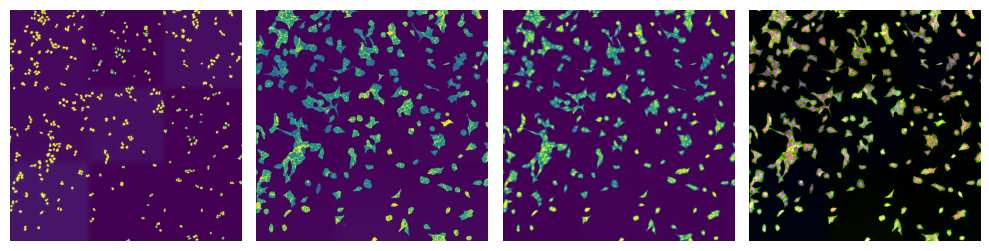

In [ ]:
# visualize input images as example
# it is not recommended to execute this block with large input images as it will compute for some time

def colorize(im, color, clip_percentile=0.0):
    """
    Helper function to create an RGB image from a single-channel image using a
    specific color.
    """
    # Check that we do just have a 2D image
    if im.ndim > 2 and im.shape[2] != 1:
        raise ValueError("This function expects a single-channel image!")

    # Rescale the image according to how we want to display it
    im_scaled = im.astype(np.float32) - np.percentile(im, clip_percentile)
    im_scaled = im_scaled / np.percentile(im_scaled, 100 - clip_percentile)
    im_scaled = np.clip(im_scaled, 0, 1)

    # Need to make sure we have a channels dimension for the multiplication to work
    im_scaled = np.atleast_3d(im_scaled)

    # Reshape the color (here, we assume channels last)
    color = np.asarray(color).reshape((1, 1, -1))
    return im_scaled * color


def generate_composite(images, colors=None, plot=False):
    if colors is None:
        colors = [(0, 0, 1), (0, 1, 0), (1, 0, 0), (1, 0, 1)]
    colorized = []
    for image, color in zip(images, colors, strict=False):
        image = colorize(image, color, 0.0)
        colorized.append(image)

    if plot:
        for i in colorized:
            plt.figure()
            plt.imshow(i)

    image = colorized[0]
    for i in range(len(colorized) - 1):
        image += colorized[i + 1]

    return np.clip(image, 0, 1)


fig, axs = plt.subplots(1, 4, figsize=(10, 4))
axs[0].imshow(project.input_image[0])
axs[0].axis("off")

axs[1].imshow(project.input_image[1])
axs[1].axis("off")

axs[2].imshow(project.input_image[2])
axs[2].axis("off")

img = generate_composite(project.input_image)

axs[3].imshow(img)
axs[3].axis("off")

fig.tight_layout()

[25/02/2025 12:17:55] GPU Status for segmentation is True and will segment using the following device mps.
[25/02/2025 12:17:56] Segmenting nucleus using the following model: nuclei
[25/02/2025 12:18:05] Segmenting cytosol using the following model: cyto2


/Users/sophia/mambaforge/envs/scPortrait_dev/lib/python3.11/site-packages/cellpose/dynamics.py:189: RuntimeWarning: invalid value encountered in divide
  mu /= (1e-60 + (mu**2).sum(axis=0)**0.5)


[25/02/2025 12:18:17] Performing filtering to match Cytosol and Nucleus IDs.
[25/02/2025 12:18:30] Removed 132 nuclei and 59 cytosols due to filtering.
[25/02/2025 12:18:30] After filtering, 394 matching nuclei and cytosol masks remain.
[25/02/2025 12:18:34] Total time to perform nucleus and cytosol mask matching filtering: 16.93 seconds
[25/02/2025 12:18:34] Segmentation seg_all_nucleus written to sdata object.
[25/02/2025 12:18:35] Points centers_seg_all_nucleus written to sdata object.
[25/02/2025 12:18:36] Segmentation seg_all_cytosol written to sdata object.
[25/02/2025 12:18:36] Points centers_seg_all_cytosol written to sdata object.


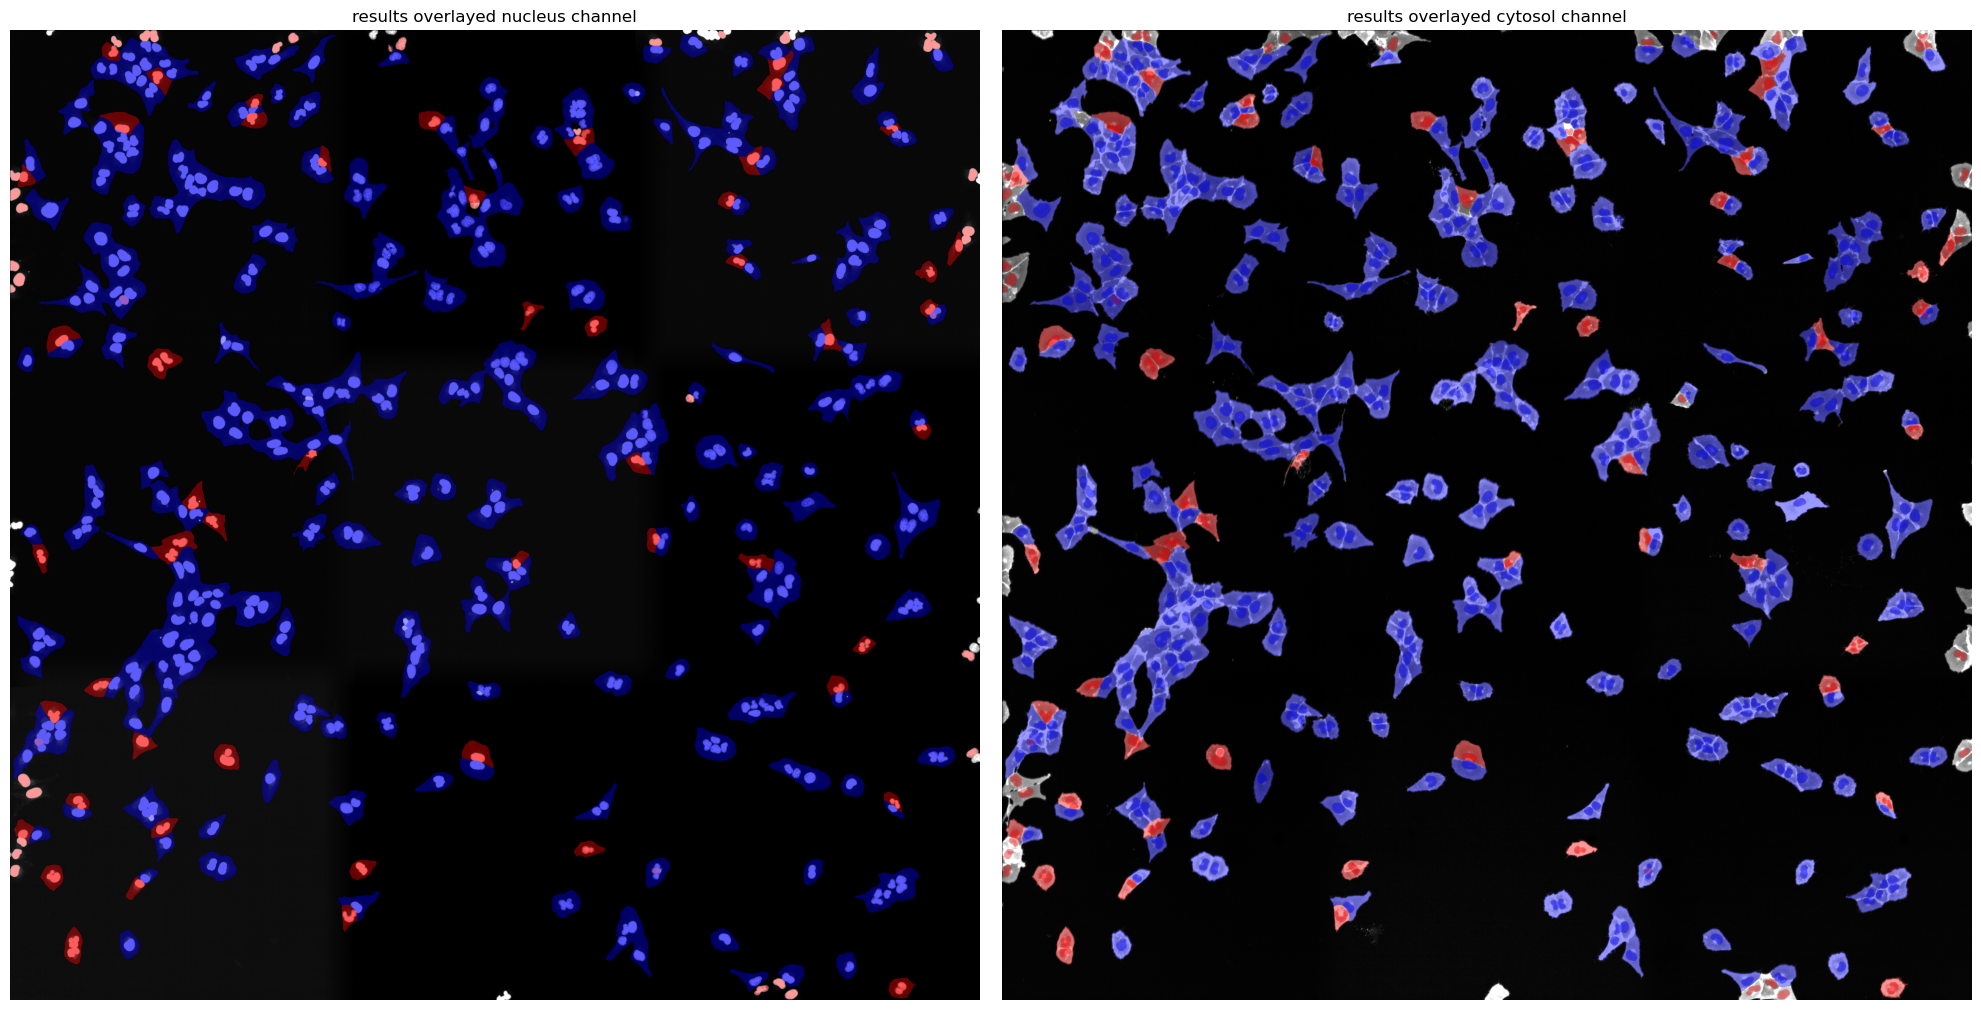

In [ ]:
project.segment()

In [ ]:
project.sdata

SpatialData object, with associated Zarr store: /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project/scportrait.sdata
├── Images
│     └── 'input_image': DataTree[cyx] (3, 3039, 3037), (3, 1519, 1518), (3, 379, 379), (3, 47, 47)
├── Labels
│     ├── 'seg_all_cytosol': DataArray[yx] (3039, 3037)
│     └── 'seg_all_nucleus': DataArray[yx] (3039, 3037)
└── Points
      ├── 'centers_seg_all_cytosol': DataFrame with shape: (<Delayed>, 2) (2D points)
      └── 'centers_seg_all_nucleus': DataFrame with shape: (<Delayed>, 2) (2D points)
with coordinate systems:
    ▸ 'global', with elements:
        input_image (Images), seg_all_cytosol (Labels), seg_all_nucleus (Labels), centers_seg_all_cytosol (Points), centers_seg_all_nucleus (Points)

(-0.5, 3036.5, 3038.5, -0.5)

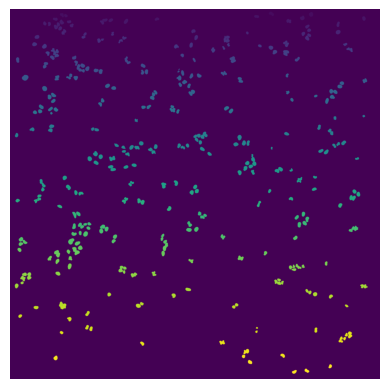

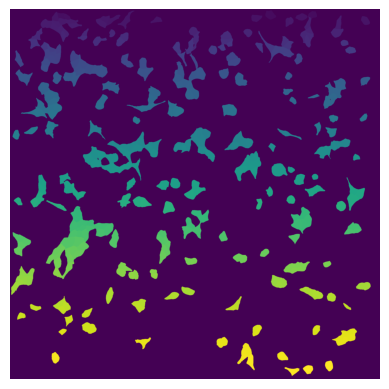

In [ ]:
plt.figure()
plt.imshow(project.sdata["seg_all_nucleus"])
plt.axis("off")

plt.figure()
plt.imshow(project.sdata["seg_all_cytosol"])
plt.axis("off")

In [ ]:
project.extract()

[25/02/2025 12:18:43] Initialized temporary directory at /var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./HDF5CellExtraction_i7vh5vxw for HDF5CellExtraction
[25/02/2025 12:18:43] Created new directory for extraction results: /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project/extraction/data
[25/02/2025 12:18:43] Setup output folder at /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project/extraction/data
[25/02/2025 12:18:43] Found 2 segmentation masks for the given key in the sdata object. Will be extracting single-cell images based on these masks: ['seg_all_nucleus', 'seg_all_cytosol']
[25/02/2025 12:18:43] Using seg_all_nucleus as the main segmentation mask to determine cell centers.
[25/02/2025 12:18:44] A total of 10 cells were too close to the image border to be extracted. Their cell_ids were saved to file /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/

Extracting cell batches: 100%|██████████| 4/4 [00:00<00:00, 14.83it/s]


[25/02/2025 12:18:44] Finished extraction in 0.52 seconds (743.87 cells / second)
[25/02/2025 12:18:45] Benchmarking times saved to file.
[25/02/2025 12:18:45] Cleaned up temporary directory at <TemporaryDirectory '/var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./HDF5CellExtraction_i7vh5vxw'>


(384, 5, 128, 128)


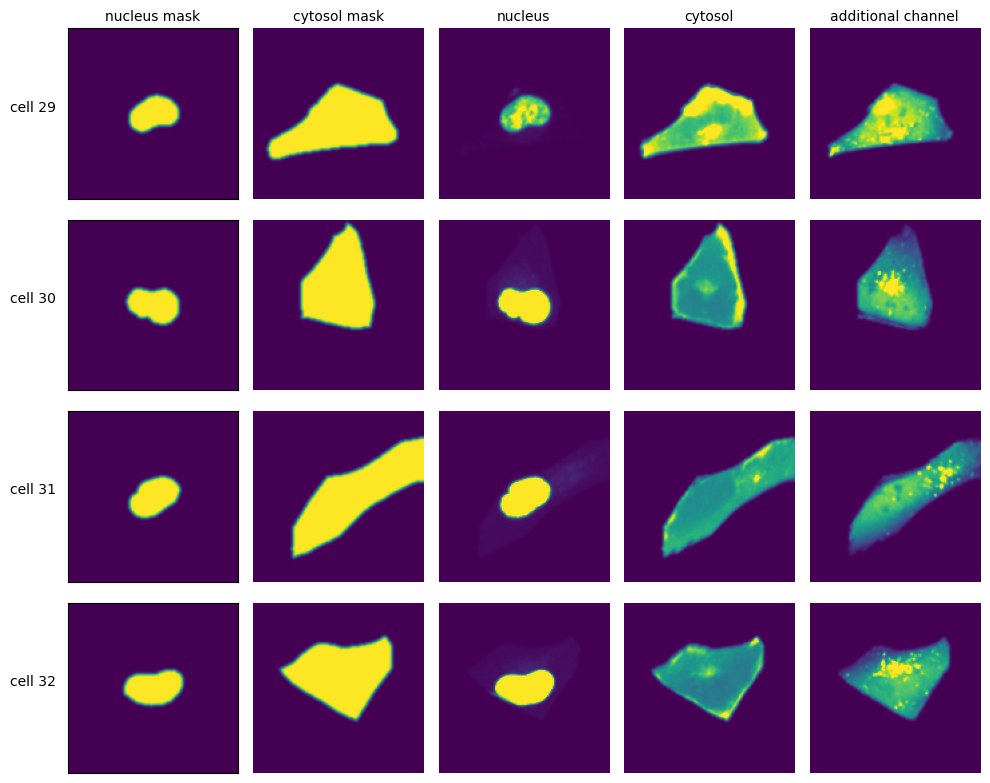

In [ ]:
with h5py.File(f"{project_location}/extraction/data/single_cells.h5") as hf:
    index = hf.get("single_cell_index")
    images = hf.get("single_cell_data")

    print(images.shape)

    n_cells = [2, 3, 4, 5]
    fig, axs = plt.subplots(len(n_cells), 5, figsize=(5 * 2, len(n_cells) * 2))
    labels = ["nucleus mask", "cytosol mask", "nucleus", "cytosol", "additional channel"]

    for i, id in enumerate(n_cells):
        cell_id = index[id][1]
        image = images[id]

        for n, _img in enumerate(image):
            axs[i, n].imshow(_img)

            if n == 0:
                axs[i, n].set_ylabel(f"cell {cell_id}", fontsize=10, rotation=0, labelpad=25)
                axs[i, n].xaxis.set_visible(False)
                axs[i, n].tick_params(left=False, labelleft=False)
            else:
                axs[i, n].axis("off")

            if i == 0:
                axs[i, n].set_title(labels[n], fontsize=10)
    fig.tight_layout()

In [ ]:
project.featurize()

Using extraction directory: /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project/extraction/data/single_cells.h5
[25/02/2025 12:18:45] Initialized temporary directory at /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/CellFeaturizer_rdxk2xl7 for CellFeaturizer
[25/02/2025 12:18:45] Started CellFeaturization of all available channels.
[25/02/2025 12:18:45] Overwrite flag is set, deleting existing directory for featurization results.
[25/02/2025 12:18:45] Created new directory for featurization results: /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project/featurization/complete_CellFeaturizer
[25/02/2025 12:18:45] CPU specified in config file but MPS available on system. Consider changing the device for the next run.
[25/02/2025 12:18:45] Reading data from path: /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project/extract

In [ ]:
# load classification results
results = pd.read_csv(f"{project_location}/featurization/complete_CellFeaturizer/calculated_image_features.csv")
results

,nucleus_area,cytosol_area,cytosol_only_area,1_mean_nucleus,1_median_nucleus,1_quant75_nucleus,1_quant25_nucleus,1_summed_intensity_nucleus,1_summed_intensity_area_normalized_nucleus,1_mean_cytosol,...,3_summed_intensity_cytosol,3_summed_intensity_area_normalized_cytosol,3_mean_cytosol_only,3_median_cytosol_only,3_quant75_cytosol_only,3_quant25_cytosol_only,3_summed_intensity_cytosol_only,3_summed_intensity_area_normalized_cytosol_only,label,cell_id
0,1667.0,5229.0,3562.0,0.076646,0.0,0.019680,0.0,1255.77280,0.352547,0.076646,...,2509.9450,0.704645,0.153195,0.0,3.272247e-02,0.0,2509.9450,0.704645,0,27
1,1389.0,4986.0,3597.0,0.062219,0.0,0.005716,0.0,1019.39810,0.283402,0.062219,...,2729.7373,0.758893,0.166610,0.0,2.770424e-03,0.0,2729.7373,0.758893,0,28
2,1279.0,4210.0,2931.0,0.037359,0.0,0.000000,0.0,612.09230,0.208834,0.037359,...,1899.3416,0.648018,0.115927,0.0,1.192093e-07,0.0,1899.3416,0.648018,0,29
3,1379.0,3974.0,2595.0,0.055688,0.0,0.000000,0.0,912.39030,0.351596,0.055688,...,1584.3878,0.610554,0.096703,0.0,0.000000e+00,0.0,1584.3878,0.610554,0,30
4,1391.0,4922.0,3531.0,0.057353,0.0,0.001249,0.0,939.67834,0.266122,0.057353,...,1739.7642,0.492711,0.106187,0.0,1.531124e-03,0.0,1739.7642,0.492711,0,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,1123.0,4138.0,3015.0,0.034677,0.0,0.000000,0.0,568.14984,0.188441,0.034677,...,1483.0164,0.491879,0.090516,0.0,0.000000e+00,0.0,1483.0164,0.491879,0,529
380,1571.0,5734.0,4163.0,0.077212,0.0,0.053429,0.0,1265.04690,0.303879,0.077212,...,2282.1113,0.548189,0.139289,0.0,8.972168e-03,0.0,2282.1113,0.548189,0,531
381,1487.0,6115.0,4628.0,0.055157,0.0,0.002697,0.0,903.68870,0.195266,0.055157,...,2233.2905,0.482561,0.136309,0.0,6.559753e-02,0.0,2233.2905,0.482561,0,535
382,1195.0,5578.0,4383.0,0.037257,0.0,0.001707,0.0,610.42200,0.139270,0.037257,...,2038.9376,0.465192,0.124447,0.0,1.148605e-02,0.0,2038.9376,0.465192,0,536
